Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [12]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.layers import Rescaling, Conv2D, Activation, MaxPooling2D, BatchNormalization, Flatten, Dense, Dropout


In [13]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/drive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [14]:
import zipfile
import os

# Paths to your Train and Test zip files in Google Drive
train_zip_path = '/content/drive/MyDrive/aiml/Train.zip'
test_zip_path = '/content/drive/MyDrive/aiml/Test.zip'

# Extract Train.zip
with zipfile.ZipFile(train_zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/train_data')

# Extract Test.zip
with zipfile.ZipFile(test_zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/test_data')

# Check the contents of the extracted directories
print("Train Data:", os.listdir('/content/train_data/Train'))
print("Test Data:", os.listdir('/content/test_data/Test'))

path_to_training_dataset = "/content/train_data/Train"
path_to_test_dataset = "/content/test_data/Test"

data_dir_train = pathlib.Path(path_to_training_dataset)
data_dir_test = pathlib.Path(path_to_test_dataset)

Train Data: ['seborrheic keratosis', 'basal cell carcinoma', 'vascular lesion', 'squamous cell carcinoma', 'dermatofibroma', 'melanoma', 'pigmented benign keratosis', 'nevus', 'actinic keratosis']
Test Data: ['seborrheic keratosis', 'basal cell carcinoma', 'vascular lesion', 'squamous cell carcinoma', 'dermatofibroma', 'melanoma', 'pigmented benign keratosis', 'nevus', 'actinic keratosis']


In [15]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [16]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [17]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [18]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [19]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

num_classes = len(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

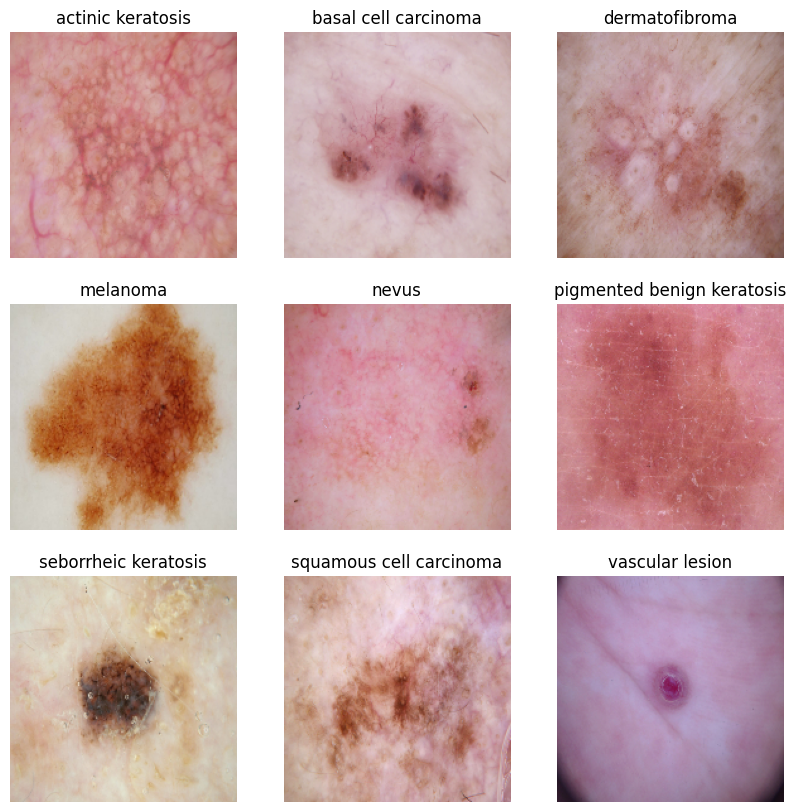

In [20]:

### your code goes here, you can use training or validation data to visualize

plt.figure(figsize=(10, 10))
plotted = set()

for images, labels in train_ds.as_numpy_iterator():
  labels_list = labels.tolist()
  for index, label in enumerate(labels_list):
    if label not in plotted:
      ax = plt.subplot(3, 3, label + 1)
      plt.imshow(images[index].astype("uint8"))
      plt.title(class_names[label])
      plt.axis("off")
      plotted.add(label)
  if len(plotted) == num_classes:
    break

In [21]:
print(f"Shape {train_ds.as_numpy_iterator().next()[0].shape}")
print(f"Labels {train_ds.as_numpy_iterator().next()[1]}")

Shape (32, 180, 180, 3)
Labels [4 8 8 3 3 4 7 5 3 4 4 5 1 6 0 5 4 3 1 1 4 2 3 3 2 4 4 6 4 0 0 3]


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

We need to conver the labels into OneHotEncoding.

In [22]:
def one_hot_encode(feature, label):
  return feature, tf.one_hot(label, depth=num_classes)

train_ds = train_ds.map(one_hot_encode)
val_ds = val_ds.map(one_hot_encode)

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [23]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(len(train_ds)).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [24]:
### Your code goes here
# from keras.layers.experimental.preprocessing import Rescaling

model = Sequential()

model.add(Rescaling(1./255, input_shape=(img_height, img_width, 3)))

model.add(Conv2D(32, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### Compile the model
Choose an appropirate optimiser and loss function for model training

In [25]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss="categorical_crossentropy",
              metrics=['accuracy'])

In [26]:
# View the summary of all layers
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 180, 180, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 180, 180, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 180, 180, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 180, 180, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 90, 90, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 90, 90, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 88, 88, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 88, 88, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 44, 44, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 123904)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      63,439,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 9)                   │           4,617 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_5 (Activation)            │ (None, 9)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 63,509,545 (242.27 MB)

 Trainable params: 63,509,545 (242.27 MB)

 Non-trainable params: 0 (0.00 B)

### Train the model

In [27]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 38s 259ms/step - accuracy: 0.1930 - loss: 2.5019 - val_accuracy: 0.3378 - val_loss: 1.8097
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - accuracy: 0.3226 - loss: 1.8377 - val_accuracy: 0.4720 - val_loss: 1.6452
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 76ms/step - accuracy: 0.4486 - loss: 1.5993 - val_accuracy: 0.5011 - val_loss: 1.4565
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - accuracy: 0.4989 - loss: 1.4452 - val_accuracy: 0.4743 - val_loss: 1.6758
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 75ms/step - accuracy: 0.5038 - loss: 1.4407 - val_accuracy: 0.4564 - val_loss: 1.6297
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 76ms/step - accuracy: 0.5106 - loss: 1.4288 - val_accuracy: 0.5235 - val_loss: 1.3993
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - accuracy: 0.5607 - loss: 1.2503 - val_accuracy: 0.4720 - val_loss: 1.5638
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 77ms/step - accuracy: 0.5486 - loss: 1.3017 - val_accuracy: 0.5280 -

### Visualizing training results

In [28]:
def plot_accuracy_loss(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(epochs)

  plt.figure(figsize=(8, 8))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()

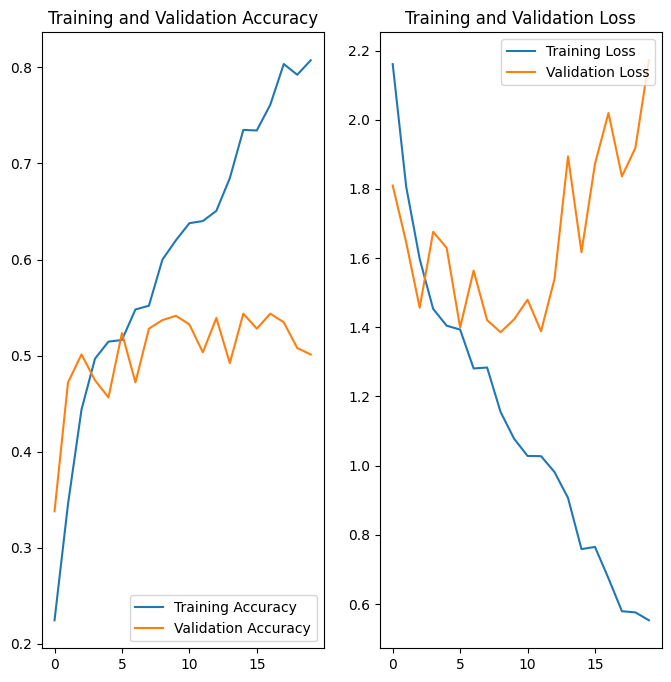

In [29]:
plot_accuracy_loss(history)

 As we can see here, the model is Overfitted now. The Training Accuracy is going up while Validation accurracy, initially, increased and then stabilizes at around 55%. We can do few things to fix this
 1. Using more data using data augmentation
 2. Adding Dropout layers and BatchNormalization Layers

### Data Augmentation

In [30]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy.
# Your code goes here

img_height = 180
img_width = 180
num_channels = 3

data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal", input_shape=(img_height, img_width, num_channels)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomTranslation(0.1, 0.1)
])

data_augmentation.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ random_flip (RandomFlip)             │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_rotation (RandomRotation)     │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_zoom (RandomZoom)             │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_translation                   │ (None, 180, 180, 3)         │               0 │
│ (RandomTranslation)                  │                             │                 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

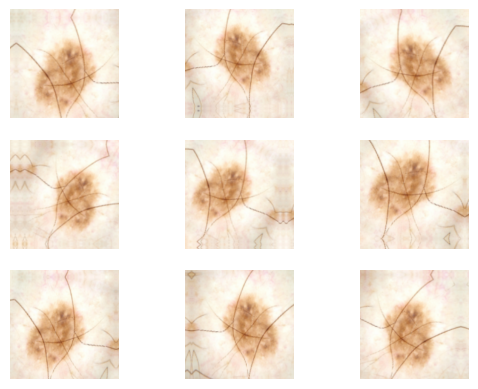

In [31]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here

for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [32]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here

model = Sequential([
    # Data augmentation layers
    layers.RandomFlip("horizontal", input_shape=(img_height, img_width, num_channels)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomTranslation(0.1, 0.1),
    # data_augmentation,

    Rescaling(1./255),

    Conv2D(32, (3, 3), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(32, (3, 3), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Conv2D(64, (3, 3), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(64, (3, 3)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Flatten(),
    BatchNormalization(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

### Compiling the model

In [33]:
## Your code goes here
model.compile(optimizer='adam',
              loss="categorical_crossentropy",
              metrics=['accuracy'])
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ random_flip_1 (RandomFlip)           │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_rotation_1 (RandomRotation)   │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_zoom_1 (RandomZoom)           │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_translation_1                 │ (None, 180, 180, 3)         │               0 │
│ (RandomTranslation)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_1 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 180, 180, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 180, 180, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_6 (Activation)            │ (None, 180, 180, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 180, 180, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 180, 180, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_7 (Activation)            │ (None, 180, 180, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 90, 90, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 90, 90, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_8 (Activation)            │ (None, 90, 90, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 88, 88, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 88, 88, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_9 (Activation)            │ (None, 88, 88, 64)          │              

 Total params: 64,005,929 (244.16 MB)

 Trainable params: 63,757,737 (243.22 MB)

 Non-trainable params: 248,192 (969.50 KB)

### Training the model

In [34]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 23s 224ms/step - accuracy: 0.2559 - loss: 31.3344 - val_accuracy: 0.2058 - val_loss: 20.9901
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 12s 207ms/step - accuracy: 0.3205 - loss: 32.6830 - val_accuracy: 0.2058 - val_loss: 26.8602
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 11s 205ms/step - accuracy: 0.3419 - loss: 28.9726 - val_accuracy: 0.2058 - val_loss: 32.5788
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 11s 204ms/step - accuracy: 0.3516 - loss: 24.0390 - val_accuracy: 0.2036 - val_loss: 25.8252
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 20s 202ms/step - accuracy: 0.3748 - loss: 17.2967 - val_accuracy: 0.2058 - val_loss: 11.1183
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 12s 206ms/step - accuracy: 0.3443 - loss: 11.9232 - val_accuracy: 0.2036 - val_loss: 9.0862
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 12s 208ms/step - accuracy: 0.3462 - loss: 6.6241 - val_accuracy: 0.1924 - val_loss: 3.9256
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 12s 208ms/step - accuracy: 0.3368 - loss: 2.3338

### Visualizing the results

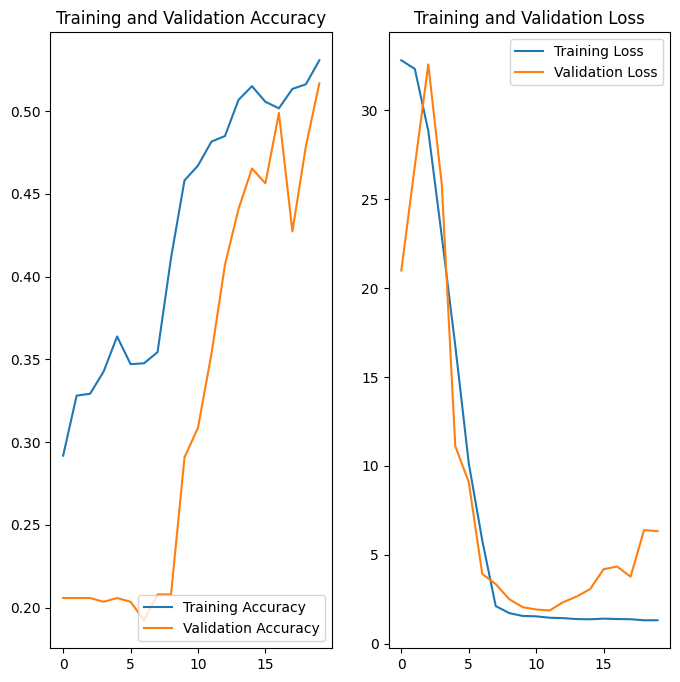

In [35]:
plot_accuracy_loss(history)

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?:
Training and Validation accuracies have reduced. Also we can see that, the model is not overfitting as much as earlier.
Though model have learned something, the overall accuracy is less. We need to address this.

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

<Figure size 640x480 with 0 Axes>

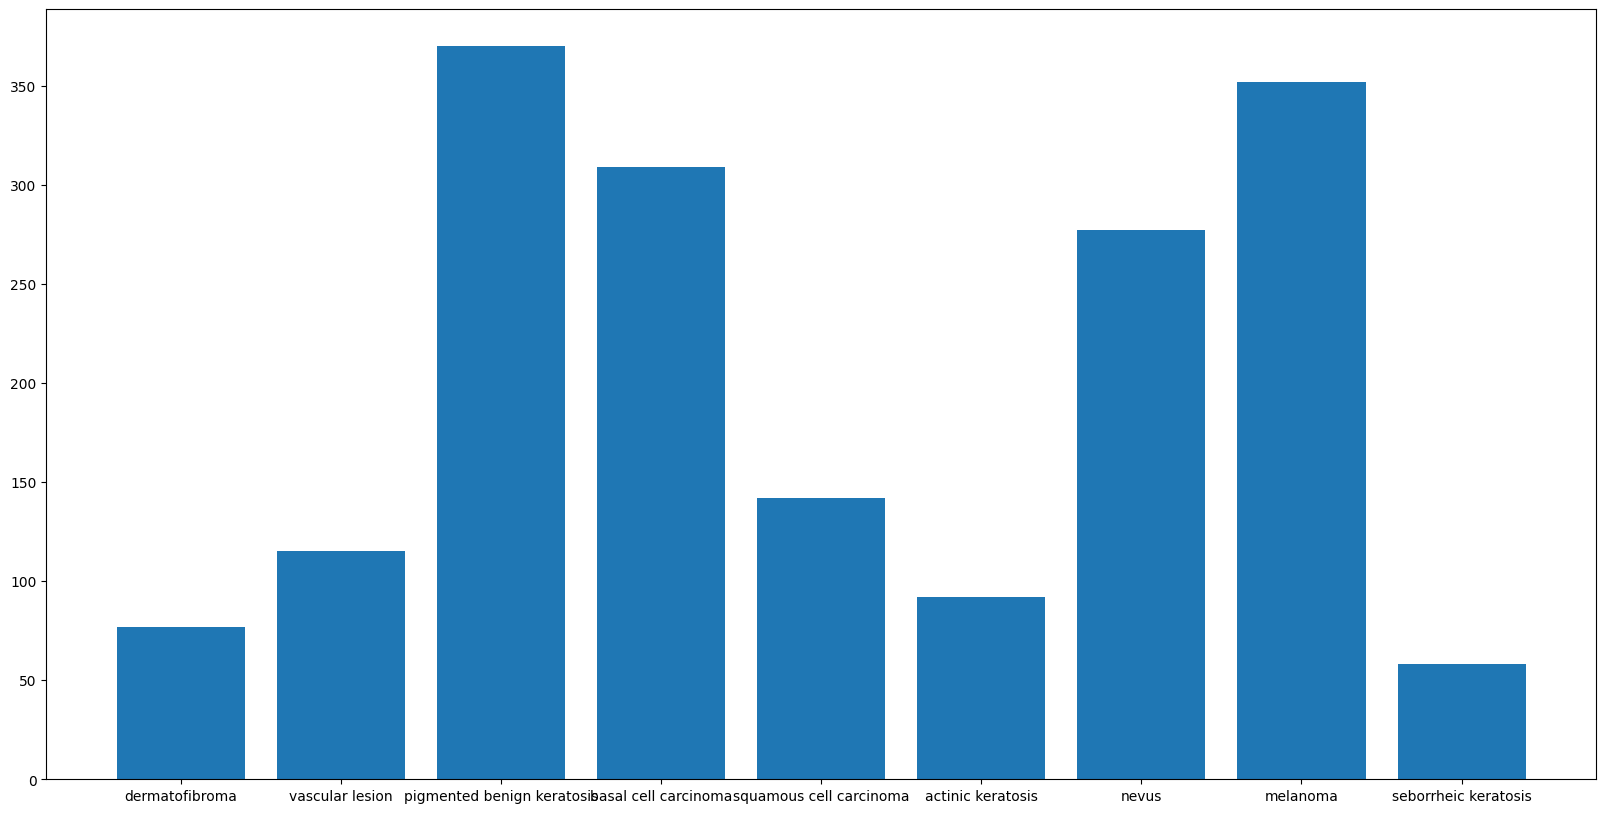

In [36]:
## Your code goes here.

data = dict()

for images, labels in train_ds.as_numpy_iterator():
  for label in labels:
    class_index = np.argmax(label)
    class_name = class_names[class_index]
    if class_name not in data:
      data[class_name] = 0
    data[class_name] += 1

f = plt.figure()
plt.figure(figsize=(20, 10))

plt.bar(range(len(data)), list(data.values()), align='center')
plt.xticks(range(len(data)), list(data.keys()))
plt.show()

#### **Todo:** Write your findings here:
#### - Which class has the least number of samples?
`seborrheic keratosis` has the least number of images. I has only around 55 images. There are others a few other classes who has less than 100 images like `dermatofibroma` and `actinic keratosis`
#### - Which classes dominate the data in terms proportionate number of samples?
Few of the classes like `pigmented benign keratosis` and `melanoma` has quite a few images compared to other.

#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [37]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [38]:
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + '/' + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/train_data/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7D89CDF870A0>: 100%|██████████| 500/500 [00:19<00:00, 25.35 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/train_data/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7D89CDD36E00>: 100%|██████████| 500/500 [00:22<00:00, 22.60 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/train_data/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7D89E9F39990>: 100%|██████████| 500/500 [00:20<00:00, 24.45 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/train_data/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=965x724 at 0x7D89CDD198D0>: 100%|██████████| 500/500 [01:26<00:00,  5.78 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/train_data/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=824x719 at 0x7D89CD7971F0>: 100%|██████████| 500/500 [01:18<00:00,  6.35 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/train_data/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7D89CDDFC220>: 100%|██████████| 500/500 [00:17<00:00, 29.11 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/train_data/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7D89CD6AD060>: 100%|██████████| 500/500 [00:38<00:00, 13.06 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/train_data/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7D89D82B7CA0>: 100%|██████████| 500/500 [00:15<00:00, 31.51 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/train_data/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7D89D80B5DB0>: 100%|██████████| 500/500 [00:15<00:00, 32.58 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [39]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [40]:
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
len(path_list)

4500

In [41]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
len(lesion_list_new)

4500

In [42]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [43]:
new_df = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])


In [44]:
new_df['Label'].value_counts()

,count
Label,
seborrheic keratosis,500
basal cell carcinoma,500
vascular lesion,500
squamous cell carcinoma,500
dermatofibroma,500
melanoma,500
pigmented benign keratosis,500
nevus,500
actinic keratosis,500


So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [45]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [46]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  path_to_training_dataset,
  seed=123,
  validation_split = 0.2,
  subset='training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [47]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  path_to_training_dataset,
  seed=123,
  validation_split = 0.2,
  subset='validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [48]:
print(f'Train: {train_ds.class_names}')
print(f'Validation: {val_ds.class_names}')

Train: ['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']
Validation: ['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [49]:
train_ds = train_ds.map(one_hot_encode)
val_ds = val_ds.map(one_hot_encode)

In [50]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(len(train_ds)).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

#### **Todo:** Create your model (make sure to include normalization)

In [65]:
# Step 1: Extract labels from train_ds
train_labels = []
for _, labels in train_ds:
    train_labels.extend(labels.numpy().tolist())  # Convert labels to a list of integers

# Step 2: Ensure train_labels is a flat list of integers
train_labels = [item for sublist in train_labels for item in sublist]  # Flatten the list if needed

# Step 3: Compute class weights
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(train_labels),  # Unique classes
    y=train_labels)  # Corresponding labels (now a flat list)

# Step 4: Convert class_weights to a dictionary
class_weights = dict(enumerate(class_weights))

# Step 5: Use class weights in model fitting
model.fit(train_ds, validation_data=val_ds, epochs=epochs, class_weight=class_weights)



Epoch 1/30


InvalidArgumentError: Graph execution error:

Detected at node GatherV2 defined at (most recent call last):
<stack traces unavailable>
Detected at node GatherV2 defined at (most recent call last):
<stack traces unavailable>
2 root error(s) found.
  (0) INVALID_ARGUMENT:  Error in user-defined function passed to MapDataset:49 transformation with iterator: Iterator::Root::Prefetch::ParallelMapV2: indices[0] = 5 is not in [0, 2)
	 [[{{node GatherV2}}]]
	 [[IteratorGetNext]]
	 [[IteratorGetNext/_2]]
  (1) INVALID_ARGUMENT:  Error in user-defined function passed to MapDataset:49 transformation with iterator: Iterator::Root::Prefetch::ParallelMapV2: indices[0] = 5 is not in [0, 2)
	 [[{{node GatherV2}}]]
	 [[IteratorGetNext]]
0 successful operations.
0 derived errors ignored. [Op:__inference_one_step_on_iterator_133030]

In [56]:
## your code goes here

# model = Sequential([
#     Rescaling(1./255, input_shape=(img_height, img_width, 3)),

#     Conv2D(32, (3, 3), padding='same'),
#     BatchNormalization(),
#     Activation('relu'),
#     Conv2D(32, (3, 3), padding='same'),
#     BatchNormalization(),
#     Activation('relu'),
#     MaxPooling2D(pool_size=(2, 2)),
#     Dropout(0.25),

#     Conv2D(64, (3, 3), padding='same'),
#     BatchNormalization(),
#     Activation('relu'),
#     Conv2D(64, (3, 3)),
#     BatchNormalization(),
#     Activation('relu'),
#     MaxPooling2D(pool_size=(2, 2)),
#     Dropout(0.25),

#     Flatten(),
#     BatchNormalization(),
#     Dense(512, activation='relu'),
#     Dropout(0.5),
#     Dense(num_classes, activation='softmax')
# ])
model = Sequential([
    Rescaling(1./255, input_shape=(img_height, img_width, 3)),

    Conv2D(32, (3, 3), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(32, (3, 3), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Conv2D(64, (3, 3), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(64, (5, 5)),  # Increase kernel size in deeper layers
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Conv2D(128, (3, 3), padding='same'),  # Additional layer with more filters
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

In [66]:
unique_labels = np.unique(train_labels)
print("Unique labels in training data:", unique_labels)
print("Expected number of classes:", num_classes)

Unique labels in training data: [0. 1.]
Expected number of classes: 9


#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [67]:
## your code goes here
model.compile(optimizer='adam',
              loss="categorical_crossentropy",
              metrics=['accuracy'])
model.summary()


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_4 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 180, 180, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_15               │ (None, 180, 180, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_19 (Activation)           │ (None, 180, 180, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_18 (Conv2D)                   │ (None, 180, 180, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_16               │ (None, 180, 180, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_20 (Activation)           │ (None, 180, 180, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, 90, 90, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_17               │ (None, 90, 90, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_21 (Activation)           │ (None, 90, 90, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_20 (Conv2D)                   │ (None, 86, 86, 64)          │         102,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_18               │ (None, 86, 86, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_22 (Activation)           │ (None, 86, 86, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_21 (Conv2D)                   │ (None, 43, 43, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_19               │ (None, 43, 43, 128)         │             512 │
│ (BatchNormalization)                 │                             │              

 Total params: 29,112,745 (111.06 MB)

 Trainable params: 29,112,105 (111.05 MB)

 Non-trainable params: 640 (2.50 KB)

#### **Todo:**  Train your model

In [68]:
epochs = 30

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 42s 164ms/step - accuracy: 0.1546 - loss: 23.9344 - val_accuracy: 0.0913 - val_loss: 2.2112
Epoch 2/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 21s 106ms/step - accuracy: 0.1827 - loss: 2.1312 - val_accuracy: 0.0802 - val_loss: 2.3366
Epoch 3/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 20s 105ms/step - accuracy: 0.2024 - loss: 2.0650 - val_accuracy: 0.2272 - val_loss: 1.9375
Epoch 4/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 21s 107ms/step - accuracy: 0.2206 - loss: 2.0238 - val_accuracy: 0.2235 - val_loss: 2.1535
Epoch 5/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 18s 108ms/step - accuracy: 0.2291 - loss: 2.0126 - val_accuracy: 0.2138 - val_loss: 1.9822
Epoch 6/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 20s 106ms/step - accuracy: 0.2212 - loss: 1.9904 - val_accuracy: 0.1923 - val_loss: 2.0073
Epoch 7/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 18s 106ms/step - accuracy: 0.2226 - loss: 1.9471 - val_accuracy: 0.2361 - val_loss: 1.9239
Epoch 8/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 20s 106ms/step - accuracy: 0.2274 - loss: 

#### **Todo:**  Visualize the model results

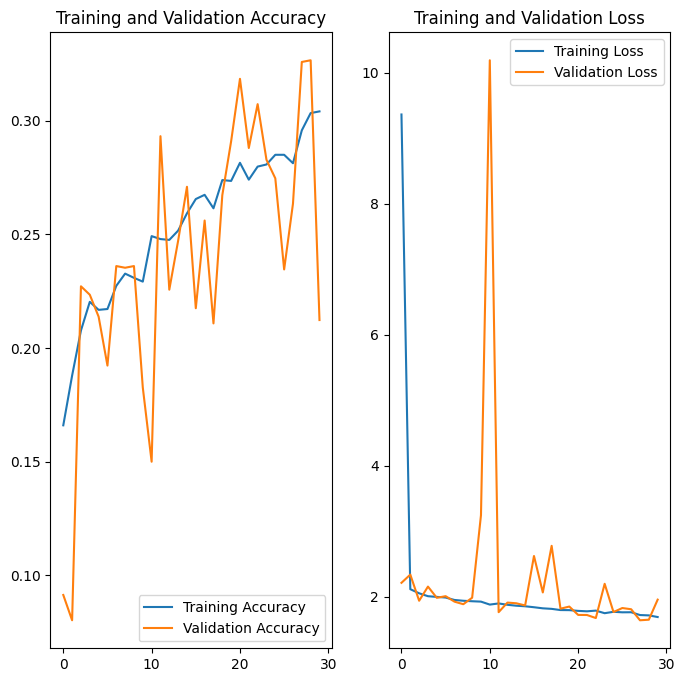

In [69]:
plot_accuracy_loss(history)

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



Rebalancing help to improve the model performance. We can see a reduction in overfitting.
Even with the improvements, the validation accuracy is only around 60%, which is not good enough. We could try to change the model architecture.